# Import package

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import calendar
import numpy as np
import pandas as pd
from pylab import rcParams
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf
from datetime import timedelta
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


E:\Application\anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 
from matplotlib.colors import ListedColormap
import plotly
import plotly.offline as py # make offline 
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
import plotly.tools as tls
import plotly.figure_factory as fig_fact
plotly.tools.set_config_file(world_readable=True, sharing='public')
import re # regular expression
import string # for finding punctuation in text
import nltk # preprocessing text

# Import Data

In [6]:
air_visit_df = pd.read_csv('air_visit_data.csv', parse_dates=['visit_date'])
air_reserve_df = pd.read_csv("air_reserve.csv", parse_dates=['reserve_datetime', 'visit_datetime'])
hpg_reserve_df = pd.read_csv("hpg_reserve.csv", parse_dates=['reserve_datetime', 'visit_datetime'])
air_store =  pd.read_csv("air_store_info.csv")
hpg_store = pd.read_csv("hpg_store_info.csv")
holidays = pd.read_csv("date_info.csv", parse_dates=['calendar_date'])
store_ids = pd.read_csv("store_id_relation.csv")
test = pd.read_csv("sample_submission.csv")

In [7]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [8]:
test.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [9]:
air_re = air_reserve.groupby(['air_store_id','visit_date'])['reserve_visitors'].sum();air_re.head()

air_store_id          visit_date
air_00a91d42b08b08d9  2016-10-31     2
                      2016-12-05     9
                      2016-12-14    18
                      2016-12-17     2
                      2016-12-20     4
Name: reserve_visitors, dtype: int64

In [10]:
hpg_re = hpg_reserve.groupby(['air_store_id','visit_date'])['reserve_visitors'].sum();hpg_re.head()

air_store_id          visit_date
air_00a91d42b08b08d9  2016-01-14    2
                      2016-01-15    4
                      2016-01-16    2
                      2016-01-22    2
                      2016-01-29    5
Name: reserve_visitors, dtype: int64

In [11]:
merge_re = pd.concat([air_re,hpg_re]).groupby(['air_store_id','visit_date']).sum(); merge_re.head()

air_store_id          visit_date
air_00a91d42b08b08d9  2016-01-14    2
                      2016-01-15    4
                      2016-01-16    2
                      2016-01-22    2
                      2016-01-29    5
Name: reserve_visitors, dtype: int64

In [12]:
air_visit_idx = air_visit.set_index(['air_store_id', 'visit_date']); air_visit_idx.head()

visitors  Month  holiday_flg  dow
air_store_id         visit_date                                   
air_ba937bf13d40fb24 2016-01-13        25      1            0    3
                     2016-01-14        32      1            0    4
                     2016-01-15        29      1            0    5
                     2016-01-16        22      1            0    6
                     2016-01-18         6      1            0    1

In [13]:
a = pd.concat([air_visit_idx, merge_re], axis=1)

In [14]:
tried = air_visit_idx.join(merge_re)

In [15]:
d = pd.concat([air_visit_idx, merge_re.rename("reserve")], axis=1,join = 'outer')

In [21]:
merge_re.describe()

count    42193.000000
mean        12.727443
std         21.434135
min          1.000000
25%          4.000000
50%          8.000000
75%         16.000000
max       2241.000000
Name: reserve_visitors, dtype: float64

In [22]:
air_visit_idx.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252108 entries, (air_ba937bf13d40fb24, 2016-01-13 00:00:00) to (air_24e8414b9b07decb, 2017-04-22 00:00:00)
Data columns (total 4 columns):
visitors       252108 non-null int64
Month          252108 non-null int64
holiday_flg    252108 non-null int64
dow            252108 non-null int64
dtypes: int64(4)
memory usage: 18.7+ MB


# Time Series

## ARIMA 

In [16]:
test['visit_date'] = test['id'].map(lambda x: str(x).split('_')[2])
test['air_store_id'] = test['id'].map(lambda x: '_'.join(x.split('_')[:2]))
test['visit_date'] = pd.to_datetime(test['visit_date'])
test['dow'] = test['visit_date'].dt.dayofweek
test['year'] = test['visit_date'].dt.year
test['month'] = test['visit_date'].dt.month
test['visit_date'] = test['visit_date'].dt.date

In [14]:
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4


In [17]:
period = len(set(test.visit_date.unique()))

In [46]:
test.visit_date.min()

datetime.date(2017, 4, 23)

In [118]:
test.visit_date.max()

datetime.date(2017, 5, 31)

In [50]:
air_visit.visit_date.max()

Timestamp('2017-04-22 00:00:00')

In [18]:
valid_pd = air_visit.visit_date.max()- timedelta(period); valid_pd

Timestamp('2017-03-14 00:00:00')

In [76]:
start_date = air_visit.visit_date.min()
end_date = air_visit.visit_date.max()

take one air store as an example to check the accuracy of the ARIMA

In [19]:
ts_all = air_visit_idx.loc[:,'visitors']
ts_id = 'air_ba937bf13d40fb24'
ts = ts_all[ts_id];ts.head()

visit_date
2016-01-13    25
2016-01-14    32
2016-01-15    29
2016-01-16    22
2016-01-18     6
Name: visitors, dtype: int64

convert int to float for ts, otherwise there will be an error

In [54]:
ts = ts.astype(float)

visit_date
2016-01-13    25.0
2016-01-14    32.0
2016-01-15    29.0
2016-01-16    22.0
2016-01-18     6.0
Name: visitors, dtype: float64

set frequency for date index, otherwise there will be an error

In [20]:
ts = ts.asfreq(freq='1d')

In [110]:
print(ts.index.freq)

<Day>


try different value for p, d, q to select the best model.

In [22]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
#warnings.filterwarnings("ignore") # specify to ignore warning messages

best_score, best_pdq, best_seasonal = float("inf"), None, None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < best_score:
                best_score, best_pdq, best_seasonal = results.aic, param,param_seasonal
                

        except:
            continue
print('ARIMA{}x{}12 - AIC:{}'.format(best_pdq, best_seasonal, best_score))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2910.6573865727505


In [23]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0361      0.017    -59.495      0.000      -1.070      -1.002
ma.S.L12      -1.0000   3599.281     -0.000      1.000   -7055.462    7053.462
sigma2       125.3218   4.51e+05      0.000      1.000   -8.84e+05    8.84e+05


E:\Application\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
E:\Application\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
E:\Application\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


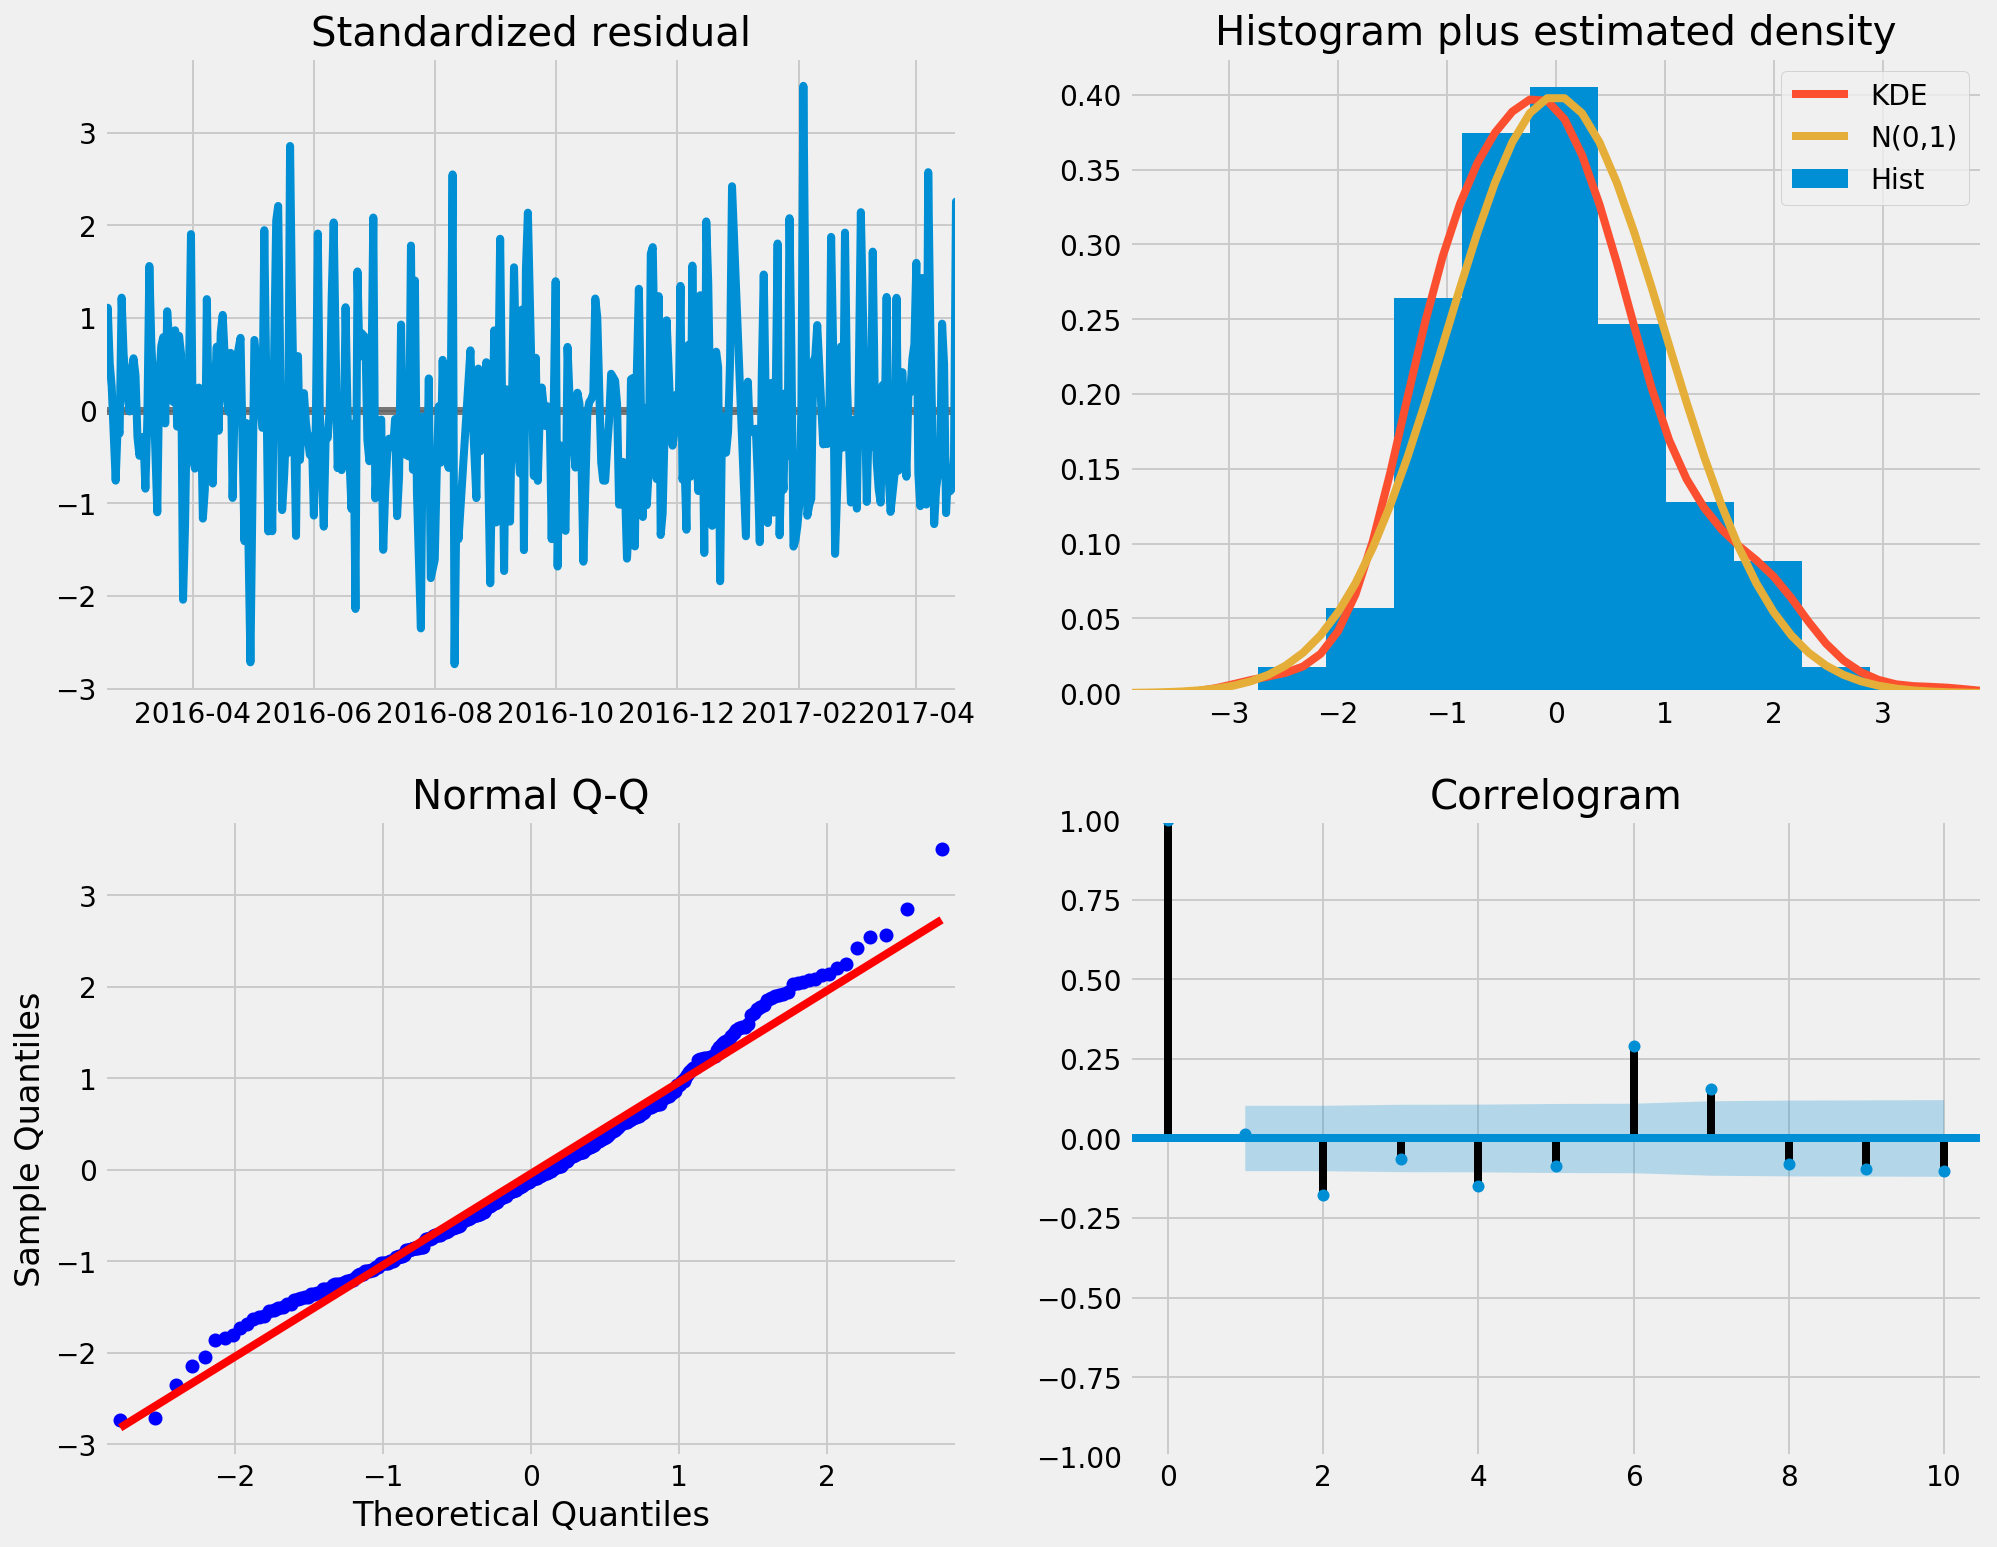

In [91]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Use same period to valid the prediction inside the sample.

In [108]:
pred = results.get_prediction(start=valid_pd, dynamic=False)
pred_ci = pred.conf_int()

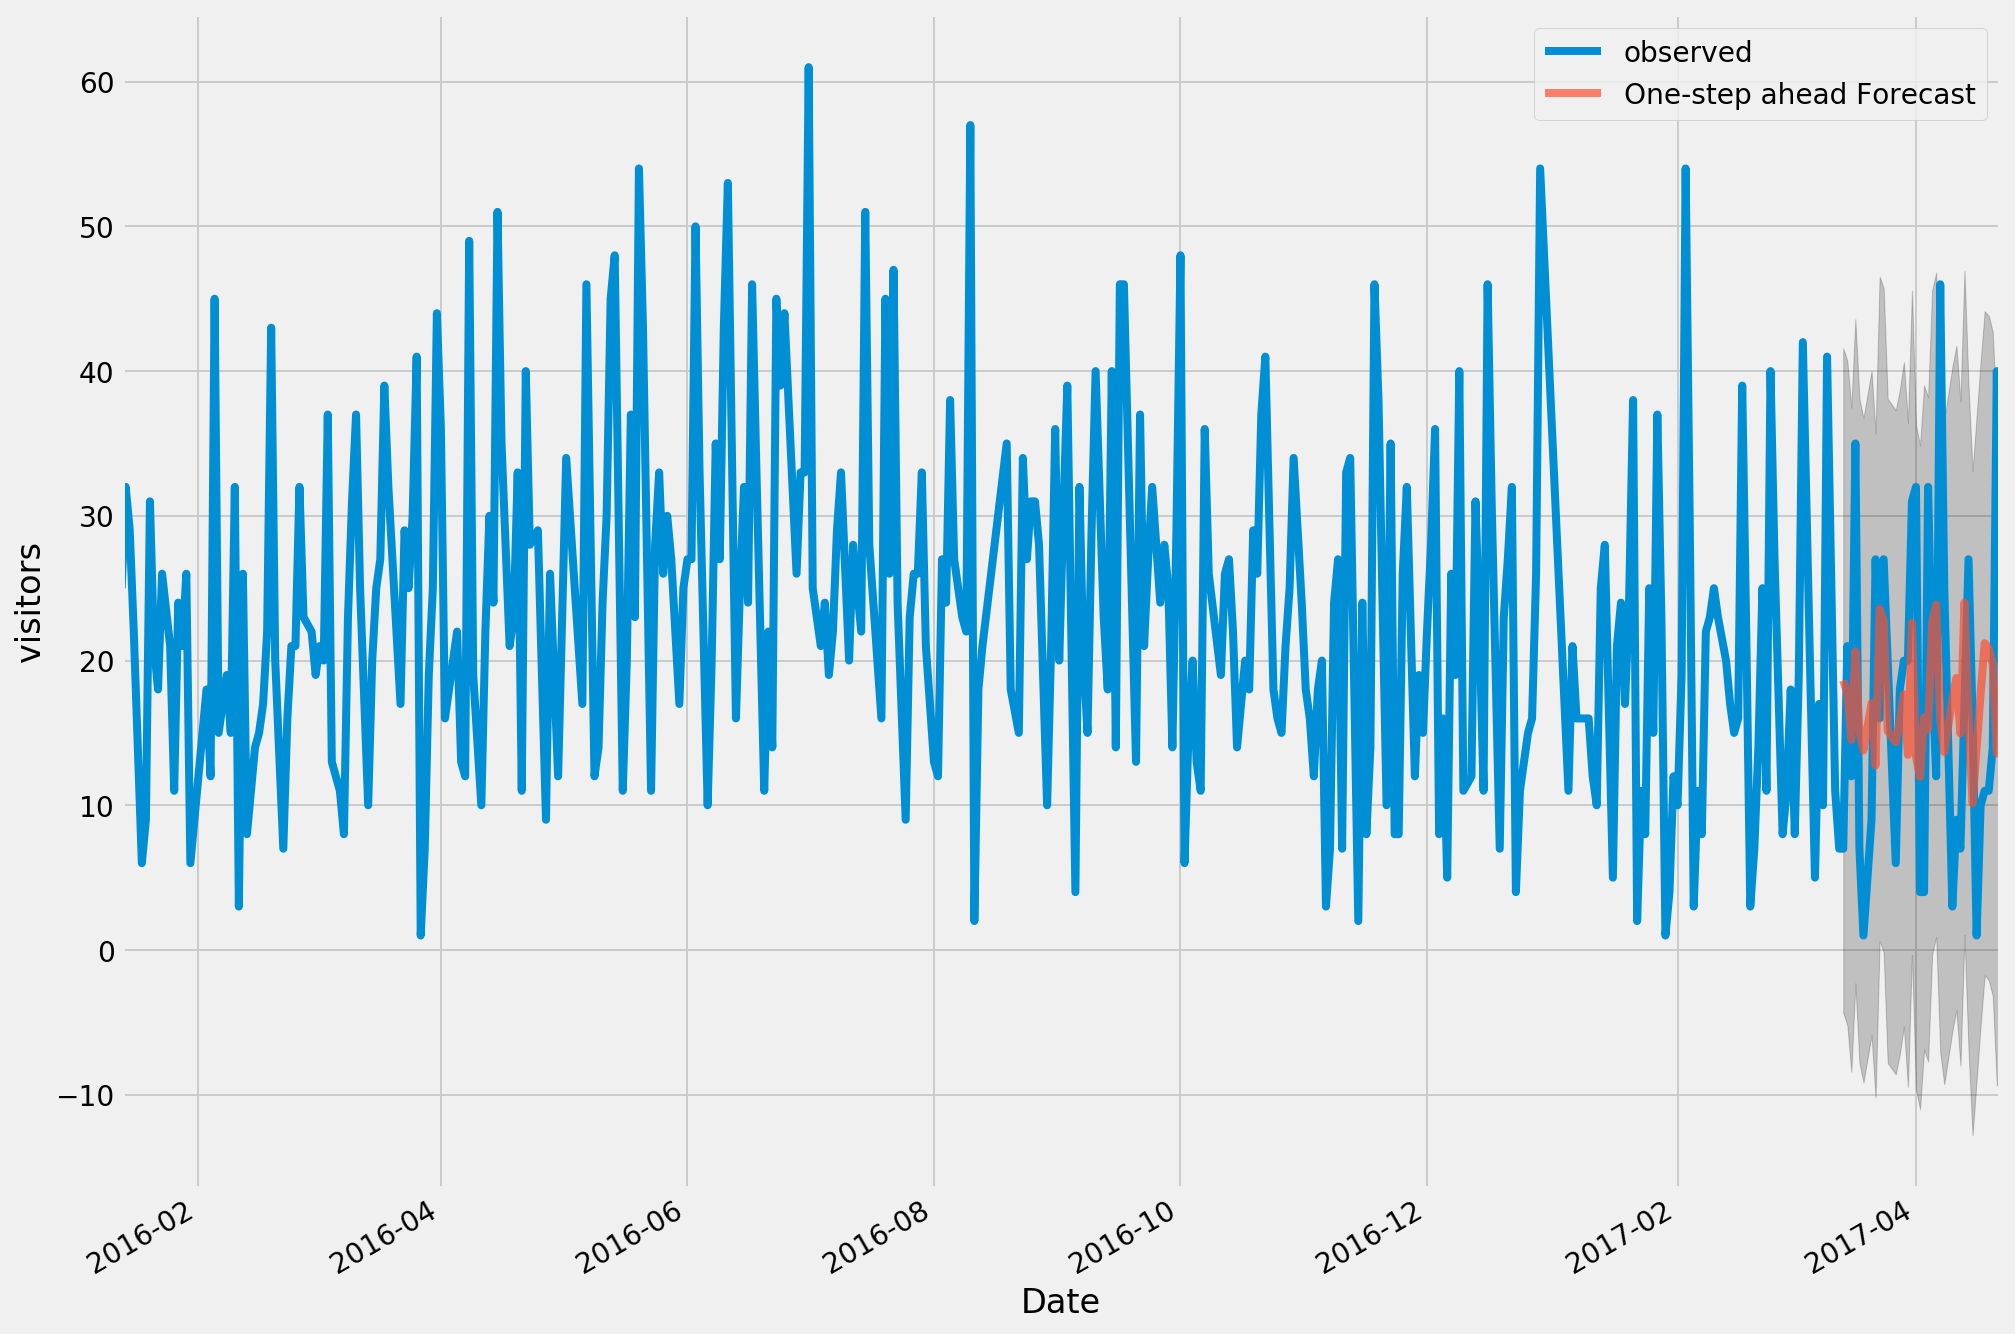

In [93]:
fig,ax = plt.subplots(figsize = (15, 12))
ax = ts[start_date:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('visitors')
plt.legend()

plt.show()

In [109]:
ts_forecasted = pred.predicted_mean
ts_truth = ts[valid_pd:]

# Compute the mean square error
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 133.08


predict visitors in the future

In [24]:
pred_uc = results.get_forecast(steps=period)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [25]:
a = pred_uc.predicted_mean
type(a)

pandas.core.series.Series

In [26]:
a.head()

2017-04-23    17.266507
2017-04-24    15.809216
2017-04-25    17.565556
2017-04-26    17.803688
2017-04-27    20.073279
Freq: D, dtype: float64

In [27]:
a.index

DatetimeIndex(['2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
               '2017-04-27', '2017-04-28', '2017-04-29', '2017-04-30',
               '2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
               '2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
               '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
               '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
               '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
               '2017-05-29', '2017-05-30', '2017-05-31'],
              dtype='datetime64[ns]', freq='D')

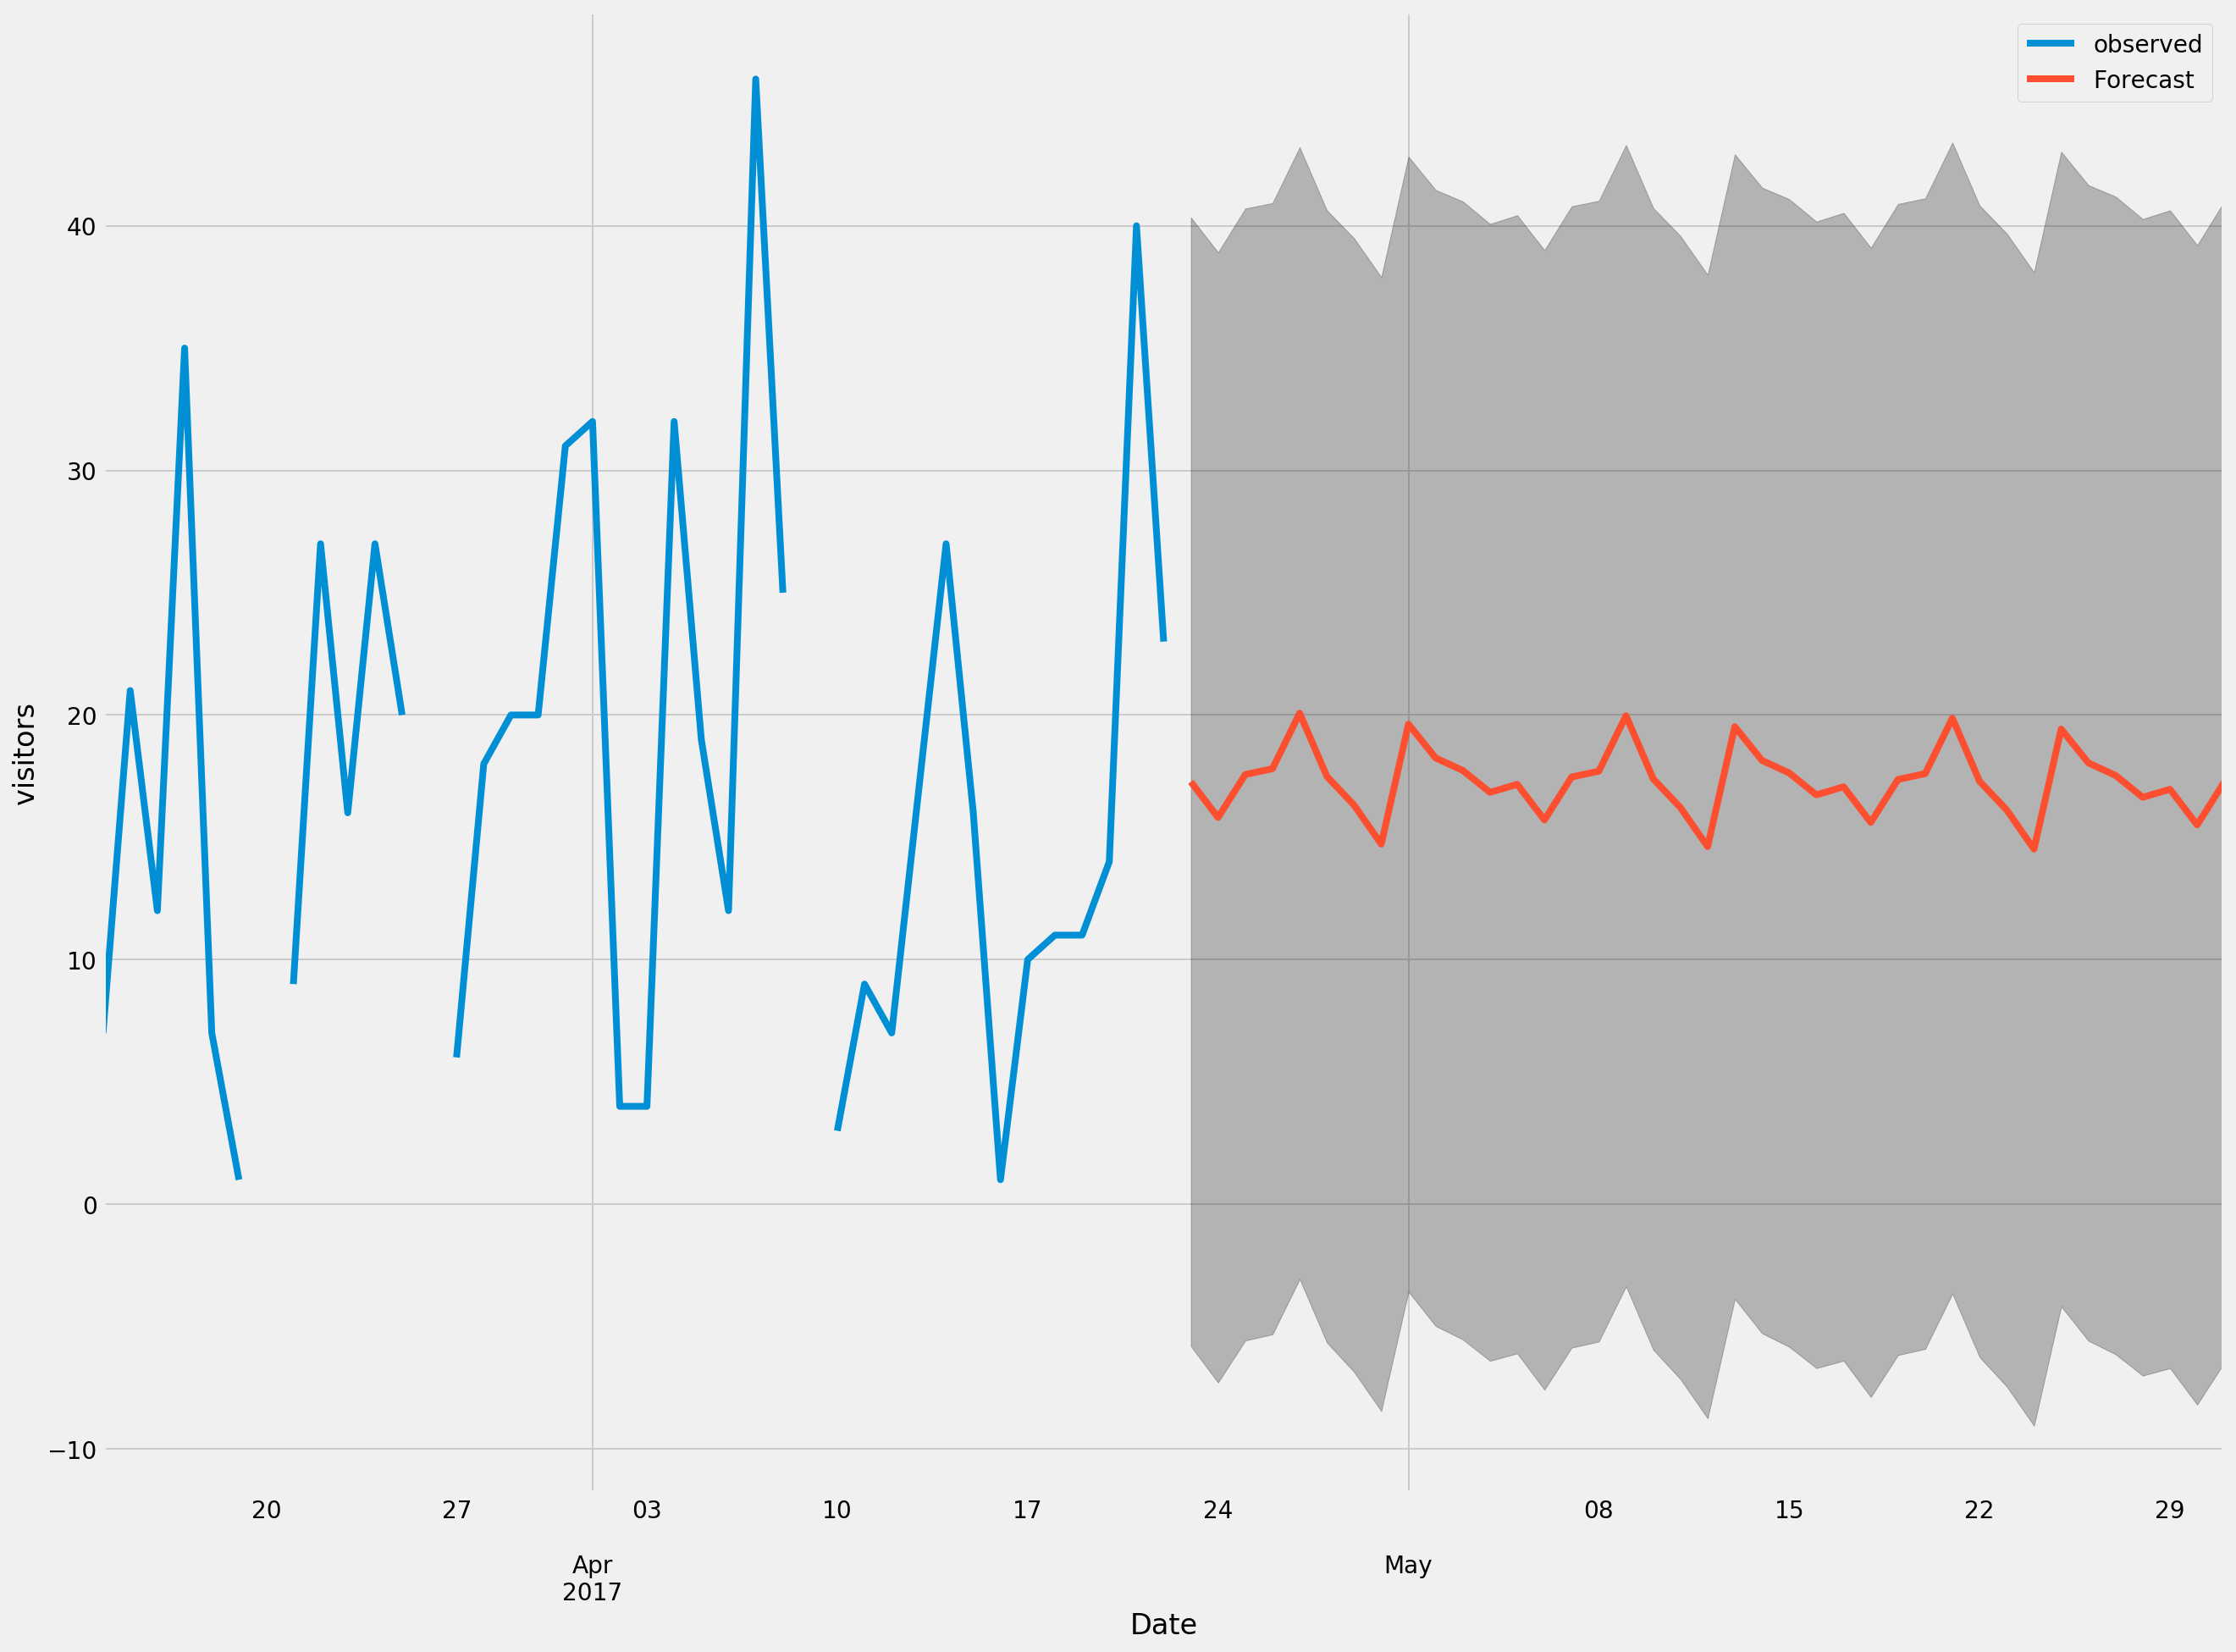

In [114]:
ax = ts[valid_pd:].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('visitors')

plt.legend()
plt.show()

Even though the result doesn't seems satisfied, we can still use this model as a reference. Now make above steps a function to apply for each store.

In [41]:
def visitor_forecast(ts):
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    best_score, best_pdq, best_seasonal = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                if results.aic < best_score:
                    best_score, best_pdq, best_seasonal = results.aic, param,param_seasonal
            except:
                continue
    mod = sm.tsa.statespace.SARIMAX(ts,
                                order=best_pdq,
                                seasonal_order=best_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    pred_uc = results.get_forecast(steps=period)
    pred_ci = pred_uc.conf_int()
    pred = pred_uc.predicted_mean
    return pred, best_score


In [29]:
store_id = set(air_visit_idx.index.get_level_values('air_store_id').unique())

In [44]:
df = pd.DataFrame([])
for i in store_id:
    ts = ts_all[i]
    ts = ts.asfreq(freq='1d')
    ts = ts.astype(float)
    df = df.append(pd.DataFrame({'air_id':i, 'visitor': visitor_forecast(ts)}), ignore_index=True)
df.head()   

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Application\anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_

,air_id,visitor
0,air_e8ed9335d0c38333,2017-04-23 23.819176 2017-04-24 25.16952...
1,air_e8ed9335d0c38333,2763.88
2,air_3e93f3c81008696d,2017-04-23 36.548047 2017-04-24 43.24286...
3,air_3e93f3c81008696d,1902.46
4,air_168441ada3e878e1,2017-04-23 43.987309 2017-04-24 43.02061...
